In [1]:
%reload_ext autoreload
%autoreload 2

import bispectrum_3D_numba as b3n

import interpolated_quantities_numba as iqn

import bispectrum_3D_numba as b3n

import numba

import matplotlib.pyplot as plt
#retina display
%config InlineBackend.figure_format = 'retina'

import temperatureinfo as ti

import numpy as np

import vegas


## Checking bispectrum

In [193]:
ls = np.arange(2, 2000, 1).astype(np.float64)

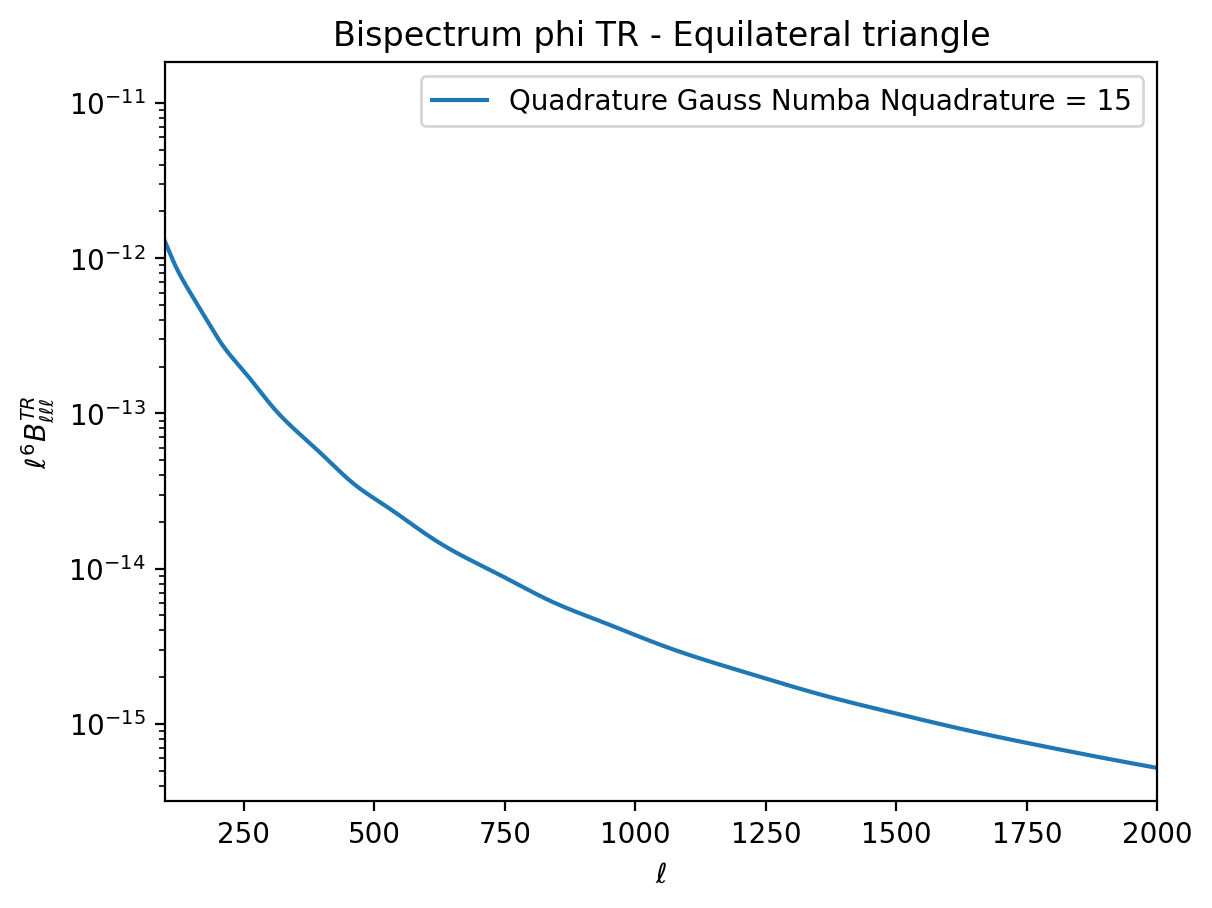

In [194]:
plt.title("Bispectrum phi TR - Equilateral triangle")
plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls, ls, ls), label = f"Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 2000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()

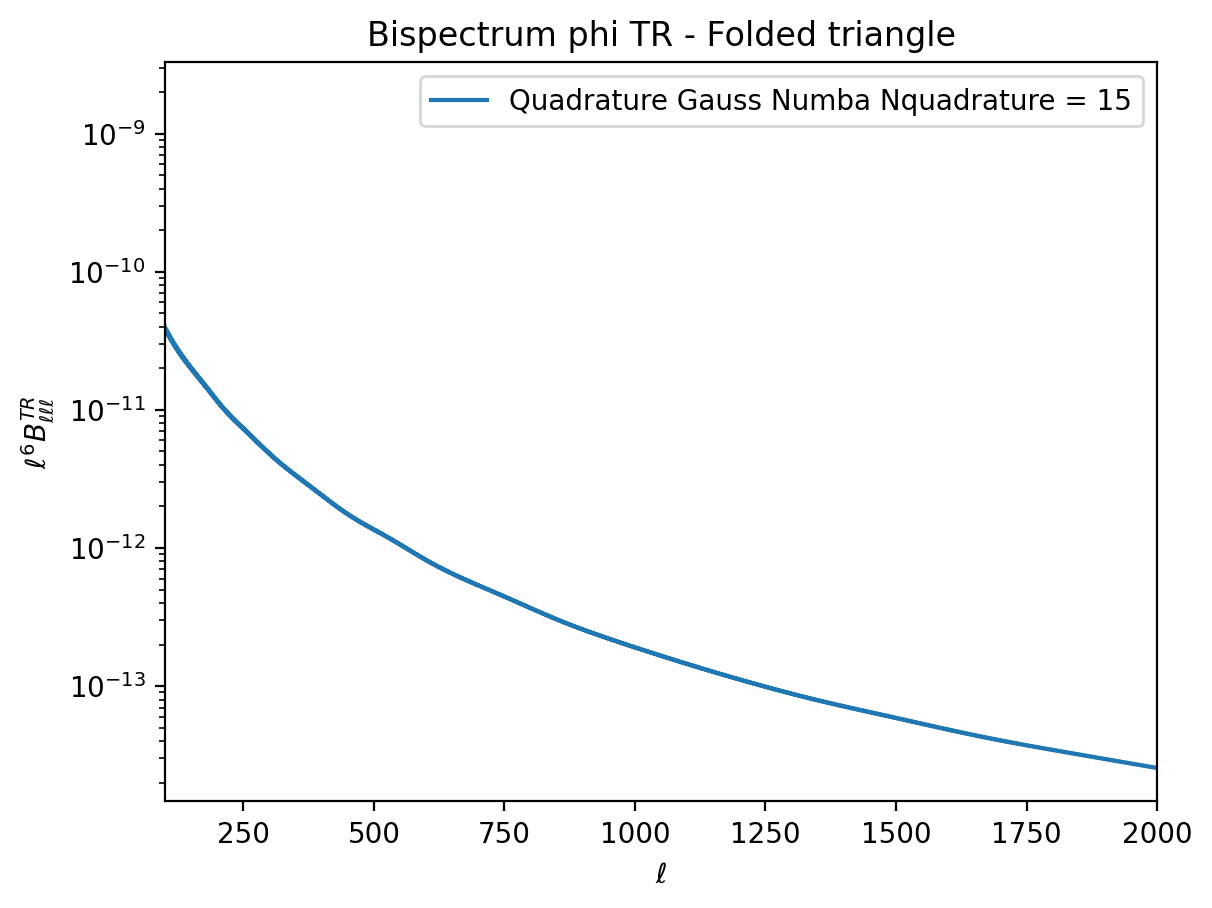

In [195]:
plt.title("Bispectrum phi TR - Folded triangle")
plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls, ls//2, ls//2), label = f"Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 2000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()

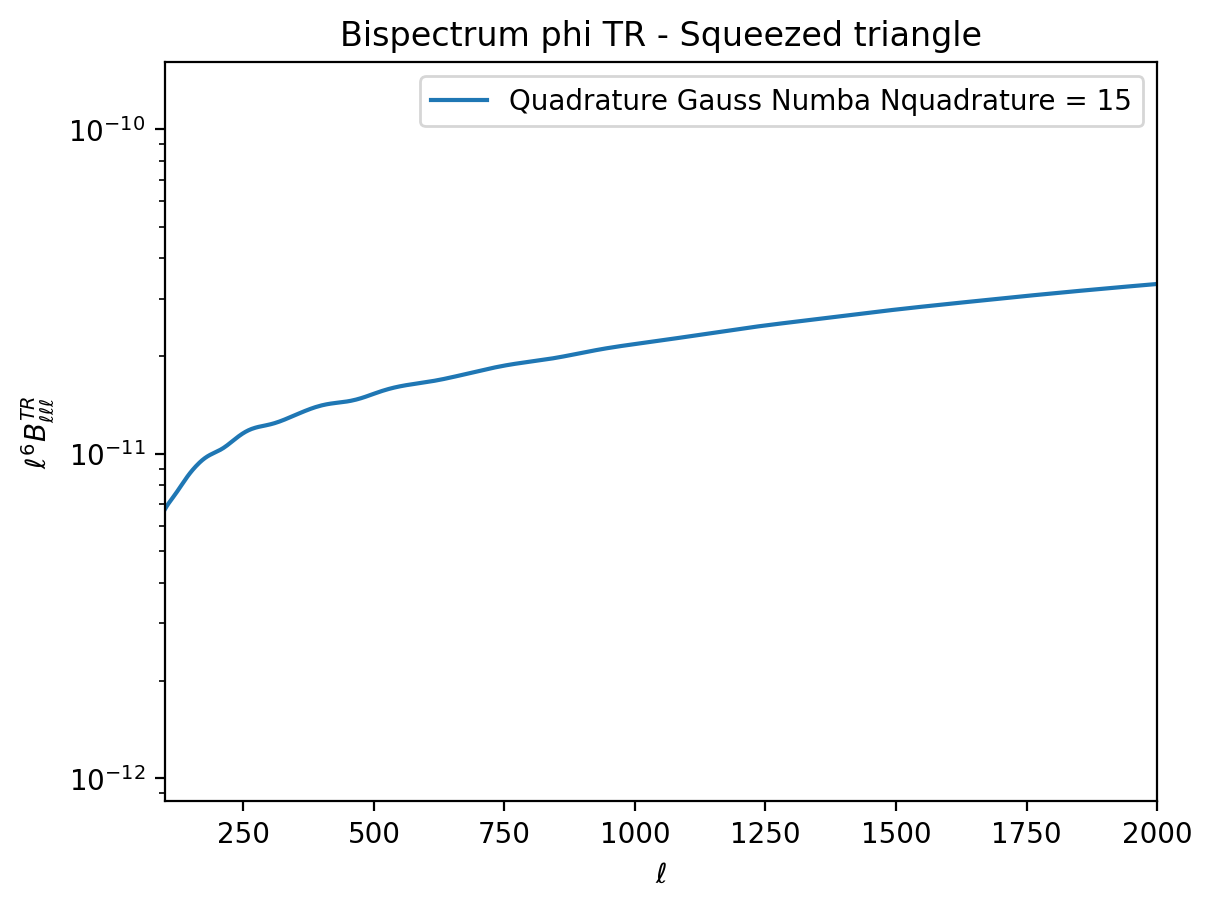

In [196]:
plt.title("Bispectrum phi TR - Squeezed triangle")
ls0 = 50
plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls0, ls, ls), label = f"Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 2000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()

## Check CMB experiment

In [7]:
import scipy as sp

/Users/omard/Documents/projects/fgcmblensing/bispectrum/temperatureinfo.py:56: RuntimeWarning: invalid value encountered in divide
  Alkappa = modlmap**4*1/integral/4
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]
/Users/omard/Documents/projects/symlens/symlens/qe.py:748: RuntimeWarning: overflow encountered in multiply
  return Al * modlmap*(modlmap+1.)/4.
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]
/Users/omard/Documents/projects/fgcmblensing/bispectrum/temperatureinfo.py:56: RuntimeWarning: invalid value encountered in divide
  Alkappa = modlmap**4*1/integral/4
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encoun

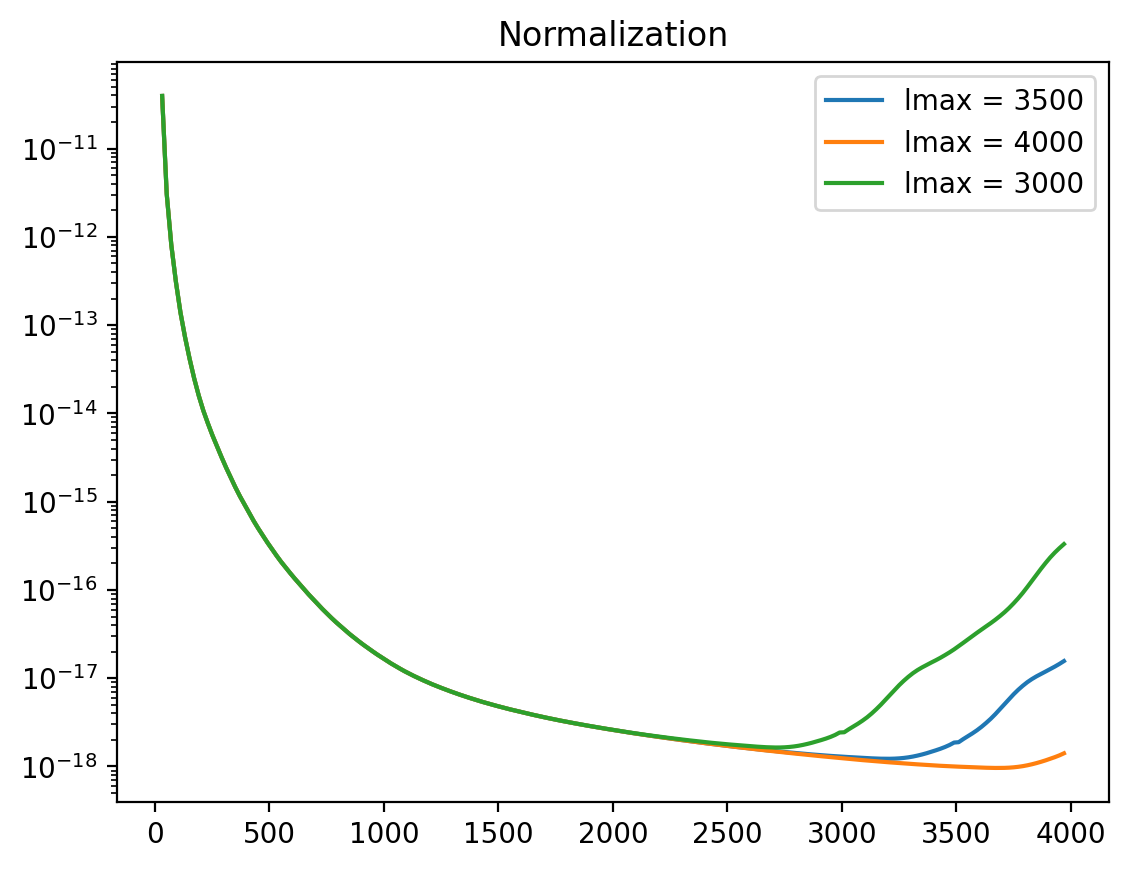

In [197]:
lmin, lmax = 10, 3500

plt.title("Normalization")
for lmax in [3500, 4000, 3000]:

    uTT, lTT, tTT = ti.get_interpolated(lmin, lmax)
    cents, Alphi = ti.get_norm(lmin, lmax)
    
    plt.plot(cents, Alphi, label = f"lmax = {lmax}")
plt.yscale("log")
plt.legend()



In [198]:
lmin, lmax = 10, 3500
print("lmin, lmax", lmin, lmax)
uTT, lTT, tTT = ti.get_interpolated(lmin, lmax)

lmin, lmax 10 3500


In [199]:
def dot(a, b):
    return np.einsum('abc, abc -> bc', a, b)

def fTT(l1v, l2v, l1n, l2n):
    return dot(l1v+l2v, l1v)*lTT(l1n)+dot(l1v+l2v, l2v)*lTT(l2n)

def ftotTT(l):
    return tTT(l)

@numba.jit
def filters(ells):
    return (ells>=lmin) & (ells<=lmax)

def gTT(lv, Lv, lvnorm):
    l1v, l2v = lv, Lv-lv
    l1n, l2n = lvnorm, np.linalg.norm(l2v, axis = 0)
    return fTT(l1v, l2v, l1n, l2n)/(2*ftotTT(l1n)*ftotTT(l2n))#*filters(l1n)*filters(l2n)

In [200]:
def integrand(R, T, Lv, g):
    lv = np.array([R * np.cos(T), R * np.sin(T)])
    return g(lv, Lv[:, None, None], R)

def get_polar_integral(g):
    def polar_integral(Lv, lmin, lmax, nthetas = 100, nrs = 1000, epstheta = 1e-4):
        theta = np.linspace(0+epstheta, 2*np.pi-epstheta, nthetas)
        r = np.linspace(lmin, lmax, nrs)
        R, T = np.meshgrid(r, theta, indexing = 'ij')
        integrand_values = integrand(R, T, Lv, g) * R
        result = np.einsum('ij->', integrand_values) * ((lmax-lmin) / nrs) * ((2*np.pi-2*epstheta) / nthetas)
        return result
    return polar_integral



def get_function(lext):
    def function(lv, Lv, lvnorm):
        resultA = gTT(lv, Lv, lvnorm)
        diff = lext-lv
        diffnorm = np.linalg.norm(diff, axis = 0)
        resultB = uTT(diffnorm)#*filters(diffnorm)
        diff_dot_lext = dot(diff, lext)
        diff_L = Lv-lext
        diff_dot_diff_L = dot(diff, diff_L)
        return resultA * resultB * diff_dot_lext * diff_dot_diff_L
    return function

def integrand_ext(lext, R, Lv, lmin, lmax, nthetas, nrs):
    result = np.zeros_like(R)
    for i in range(nrs):
        for j in range(nthetas):
            l_ = lext[:, i, j]
            f = get_function(l_[:, None, None])
            polar_integrals = get_polar_integral(f)
            result[i, j] = polar_integrals(Lv, lmin, lmax, nthetas, nrs)
    return result


def polar_integral_ext(integrand_ext, Lv, lmin, lmax, nthetas = 100, nrs = 100, epstheta = 1e-3):
    theta = np.linspace(0+epstheta, 2*np.pi-epstheta, nthetas)
    r = np.linspace(lmin, lmax, nrs)
    Rext, Text = np.meshgrid(r, theta, indexing = 'ij')
    lext = np.array([Rext * np.cos(Text), Rext * np.sin(Text)])
    integrand_values = integrand_ext(lext, Rext, Lv, lmin, lmax, nthetas, nrs) * Rext
    L1 = Lv[:, None, None]
    L2 = lext
    L3 = L1-lext
    L1mod = Lv[0].astype(np.int64)
    L2mod = Rext.astype(np.int64)
    L3mod = np.linalg.norm(L3, axis = 0).astype(np.int64)
    #print('Shape', integrate_bispectrum_kkk_alt(L1mod, L2mod, L3mod, thet12, thet23, thet13, model = "TR").shape)
    bispectrum_term = b3n.bispec_phi_TR(L1mod, L2mod, L3mod) #8/(L1mod*(L1mod+1)*L2mod*(L2mod+1)*L3mod*(L3mod+1))*integrate_bispectrum_kkk_alt(L1mod, L2mod, L3mod, thet12, thet23, thet13, model = "TR")
    #bispectrum_term = 1.
    integrand_values *= bispectrum_term
    result = np.einsum('ij->', integrand_values) * ((lmax-lmin) / nrs) * ((2*np.pi-2*epstheta) / nthetas)
    return result/(2.*np.pi)**2/(2.*np.pi)**2

In [201]:
from joblib import Parallel, delayed

batch_size = 5
n_jobs = 4
backend = "threading"

In [503]:
def do(LL):
    Lv = np.array([LL, 0])
    return -polar_integral_ext(integrand_ext, Lv, lmin, lmax, nthetas = 80, nrs = 100)*np.interp(LL, cents, Alphi)

In [504]:
Llist = np.linspace(50, 2000, 20)

In [505]:
results = Parallel(n_jobs = n_jobs, batch_size = batch_size, backend=backend, verbose=0)(delayed(do)(LL) for LL in Llist)

[[1.96649887e-23 1.96649887e-23 1.96649887e-23 ... 1.96649887e-23
  1.96649887e-23 1.96649887e-23]
 [2.21966375e-24 2.21966375e-24 2.16559338e-24 ... 2.16559338e-24
  2.21966375e-24 2.21966375e-24]
 [1.52399228e-24 1.52399228e-24 1.42392853e-24 ... 1.42392853e-24
  1.52399228e-24 1.52399228e-24]
 ...
 [1.28415894e-33 1.28435990e-33 1.28455352e-33 ... 1.28455352e-33
  1.28435990e-33 1.28415894e-33]
 [1.21363367e-33 1.21363367e-33 1.21402392e-33 ... 1.21402392e-33
  1.21363367e-33 1.21363367e-33]
 [1.14532304e-33 1.14532304e-33 1.14575715e-33 ... 1.14575715e-33
  1.14532304e-33 1.14532304e-33]]
[[1.62172704e-25 1.62172704e-25 1.61838844e-25 ... 1.61838844e-25
  1.62172704e-25 1.62172704e-25]
 [1.14810579e-26 1.14810579e-26 1.14021720e-26 ... 1.14021720e-26
  1.14810579e-26 1.14810579e-26]
 [3.97157025e-27 3.97157025e-27 3.93519724e-27 ... 3.93519724e-27
  3.97157025e-27 3.97157025e-27]
 ...
 [1.01702896e-34 1.01657836e-34 1.01477388e-34 ... 1.01477388e-34
  1.01657836e-34 1.01702896e-34]

In [509]:
bias_simple_sum = np.array(results)

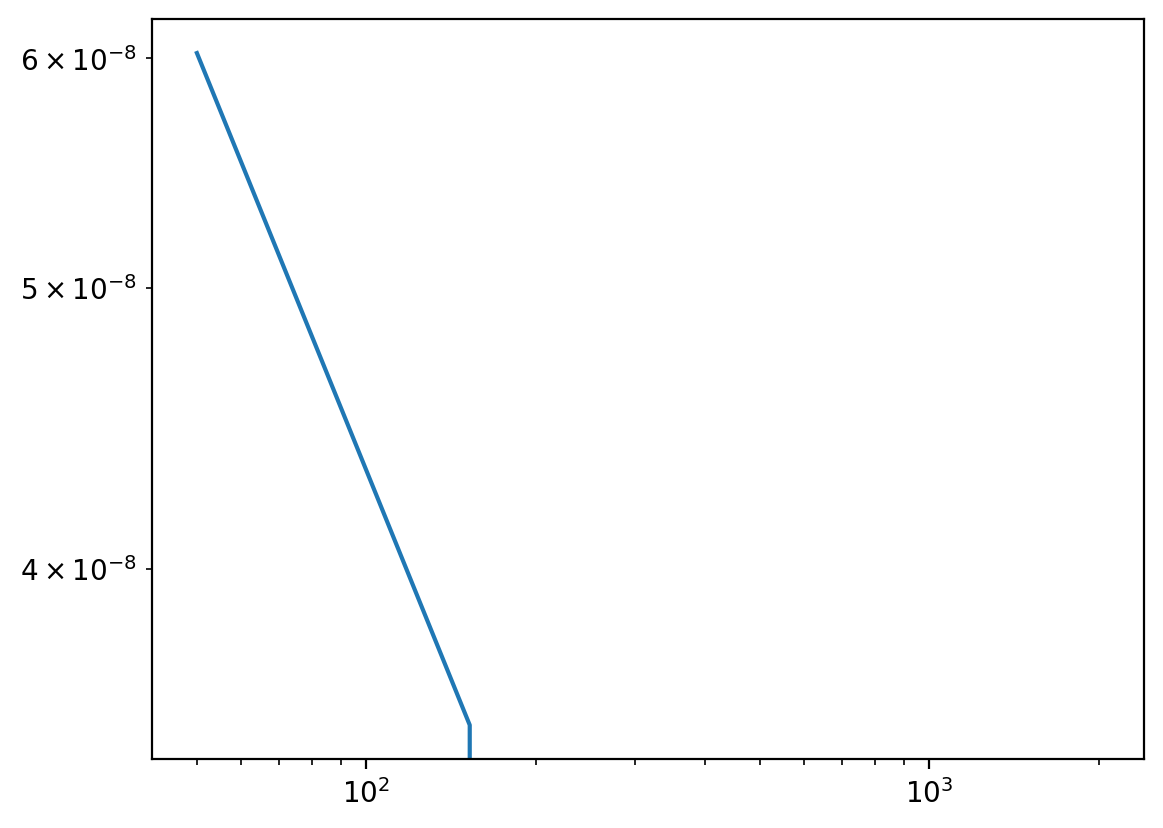

In [525]:
plt.loglog(Llist, Llist**4*bias_simple_sum, label = "Simple sum")

## Use Vegas for the integration

In [202]:
lmin, lmax = 100, 3500
print("lmin, lmax", lmin, lmax)
noise, beam = 7., 1.4
uTT, lTT, tTT = ti.get_interpolated(lmin, lmax, noise, beam)

lmin, lmax 100 3500


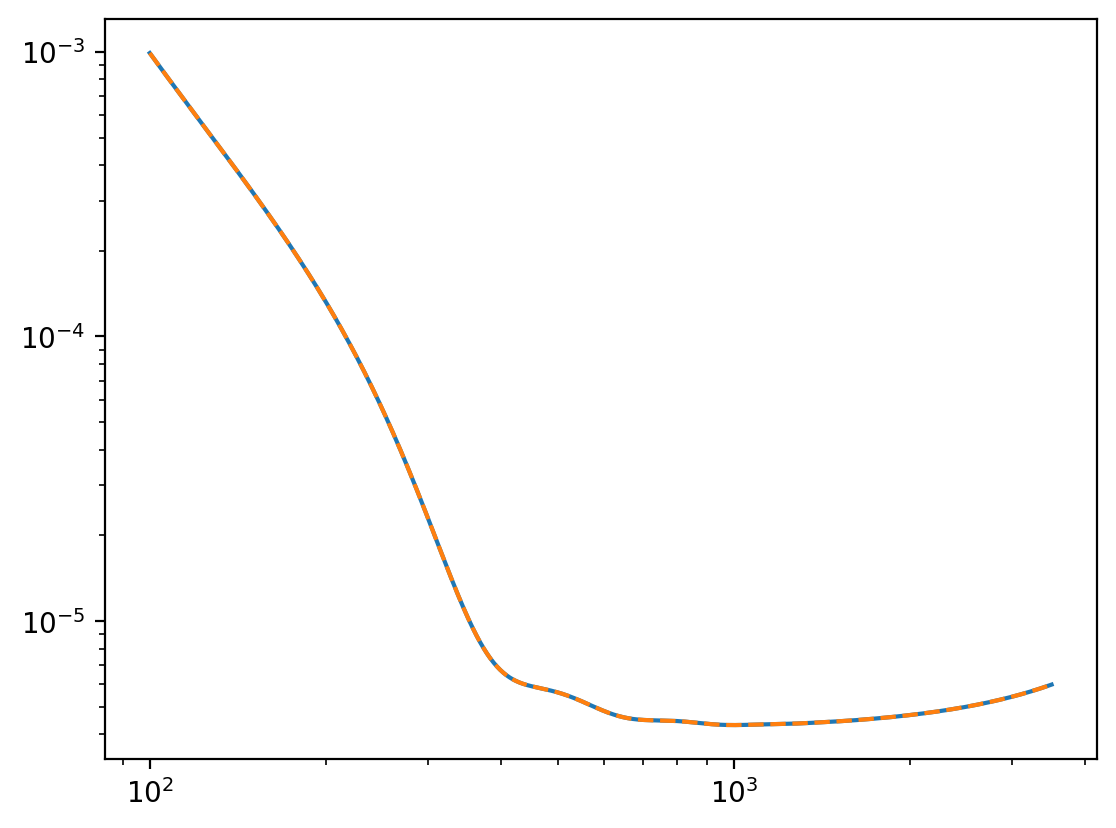

In [203]:
xlc = 180*np.sqrt(8.*np.log(2.))/np.pi
sigma2 = (beam/60/xlc)**2
noiseexp = (noise*np.pi/180./60)**2*np.exp(l__*(l__+1)*sigma2)

l__ = np.arange(lmin, lmax+1)
tTTnew = sp.interpolate.interp1d(l__, lTT(l__)+noiseexp, fill_value = 1e20, bounds_error = False)

plt.loglog(l__, tTTnew(l__))
plt.loglog(l__, tTT(l__), ls = '--')

In [204]:
import vegas

In [205]:
def dotbatch(a, b):
    return a[0, :]*b[0, :]+a[1, :]*b[1, :]

    
def funlTTbatch(l1v, l2v, l1n, l2n):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*uTT(l1n)+dotbatch(Lv, l2v)*uTT(l2n)

def flenTTbatch(l1v, l2v, l1n, l2n):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*lTT(l1n)+dotbatch(Lv, l2v)*lTT(l2n)

def fgradTTbatch(l1v, l2v, l1n, l2n):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*lTT(l1n)+dotbatch(Lv, l2v)*lTT(l2n)

def ftotTTfTTbatch(l):
    return tTT(l)

def gfTTbatch(lv, Lv, l1n, l2n):
    l1v, l2v = lv, Lv-lv
    return flenTTbatch(l1v, l2v, l1n, l2n)/(2*ftotTTfTTbatch(l1n)*ftotTTfTTbatch(l2n))

def gfTTbatch_for_modes(l1v, l2v, l1n, l2n):
    return flenTTbatch(l1v, l2v, l1n, l2n)/(2*ftotTTfTTbatch(l1n)*ftotTTfTTbatch(l2n))

### Get normalization to check the vegas code

In [206]:
Ls = np.arange(20, 3000, 100)

In [207]:
integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
nitn, neval = 100, 1e3

ALMC = []

for LL in Ls:
    @vegas.batchintegrand
    def integrand(x):
        l1, theta1 = x.T
        l1v = np.array([l1*np.cos(theta1), l1*np.sin(theta1)])
        L = np.ones_like(l1)*LL
        Lv = np.c_[L, np.zeros_like(l1)].T
        l3v = Lv-l1v

        l3 = np.linalg.norm(l3v, axis = 0)

        fXY = fTTbatch(l1v, l3v, l1, l3)

        gXY = gfTTbatch_for_modes(l1v, l3v, l1, l3)

        product = fXY*gXY     
        common = l1/(2*np.pi)**2

        return product*common
    
    result = integ(integrand, nitn = nitn, neval = neval)
    ALMC += [result.mean]

ALMC = np.array(ALMC)**-1.



In [208]:
cents, Alphi = ti.get_norm(lmin, lmax, noise, beam)

/Users/omard/Documents/projects/fgcmblensing/bispectrum/temperatureinfo.py:56: RuntimeWarning: invalid value encountered in divide
  Alkappa = modlmap**4*1/integral/4
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]
/Users/omard/Documents/projects/symlens/symlens/qe.py:748: RuntimeWarning: overflow encountered in multiply
  return Al * modlmap*(modlmap+1.)/4.
/Users/omard/Documents/projects/symlens/symlens/utils.py:170: RuntimeWarning: invalid value encountered in divide
  res = np.bincount(self.digitized,(data2d).reshape(-1))[1:-1]/np.bincount(self.digitized)[1:-1]


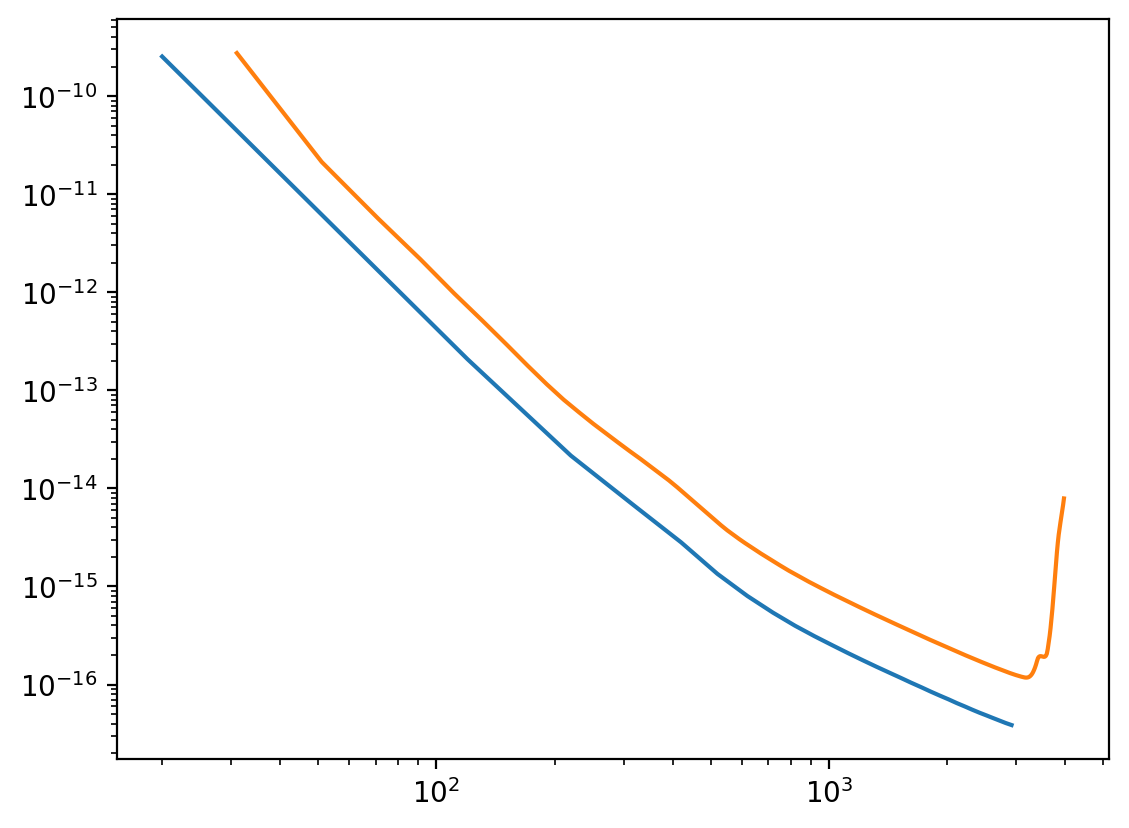

In [209]:
plt.loglog(Ls, ALMC)
plt.loglog(cents, Alphi)

### Now get the $N^{(3/2)}$ bias

In [223]:
integ = vegas.Integrator([[lmin, lmax], [lmin, lmax], [0, 2*np.pi], [0, 2*np.pi]])
nitn, neval = 100, 1e3

In [250]:
NA1 = []
NC1 = []

for LL in Ls:
    @vegas.batchintegrand
    def integrand(x):
        l1, l2, theta1, theta2 = x.T
        l1v, l2v = np.array([l1*np.cos(theta1), l1*np.sin(theta1)]), np.array([l2*np.cos(theta2), l2*np.sin(theta2)])
        L = np.ones_like(l1)*LL
        Lv = np.c_[L, np.zeros_like(l1)].T
        l3v = Lv-l1v
        l4v = Lv-l2v
        l5v = l1v-l2v

        l5 = np.linalg.norm(l5v, axis = 0)
        l4 = np.linalg.norm(l4v, axis = 0)
        l3 = np.linalg.norm(l3v, axis = 0)

        l5vdotl1v = dotbatch(l5v, l1v)
        l5vdotl3v = dotbatch(l5v, l3v)

        l2vdotl1v = dotbatch(l2v, l1v)
        l2vdotl3v = dotbatch(l2v, l3v)

        h_5_2_X = 1
        h_5_4_Y = 1

        h_2_4_Y = 1
        h_2_4_X = 1
 
        cl5_XY = uTT(l5)

        cl2_XY = uTT(l2)
        cl2_YX = cl2_XY

        gXY = gfTTbatch_for_modes(l2v, l4v, l2, l4)
        productA1 = (-1)*l5vdotl1v*l5vdotl3v*cl5_XY*h_5_2_X*h_5_4_Y*gXY

        #assume for now X = Y
        gYX = gXY 
        productC1 = 1/2*(gXY*cl2_XY*h_2_4_Y+gYX*cl2_YX*h_2_4_X)*l2vdotl1v*l2vdotl3v

        bispectrum_result = b3n.bispec_phi_GM(l1, l3, L)
        common = l1*l2*bispectrum_result/(2*np.pi)**4

        #return [common*productA1, common*productC1]
        return {'A1': common*productA1, 'C1': common*productC1}
    
    result = integ(integrand, nitn = nitn, neval = neval)
    NA1 += [result['A1'].mean]
    NC1 += [result['C1'].mean]

NA1 = np.array(NA1)
NC1 = np.array(NC1)

In [ ]:
ALinterp = ALMC#np.interp(Ls, cents, Alphi)
ppinterp = np.interp(Ls, ti.l, ti.pp)

In [ ]:
#l, potential = np.loadtxt('/Users/omard/Downloads/potential_from_camb_demuni.txt', unpack = True)
#ppinterp = np.interp(Ls, l, potential)

(20, 3000)

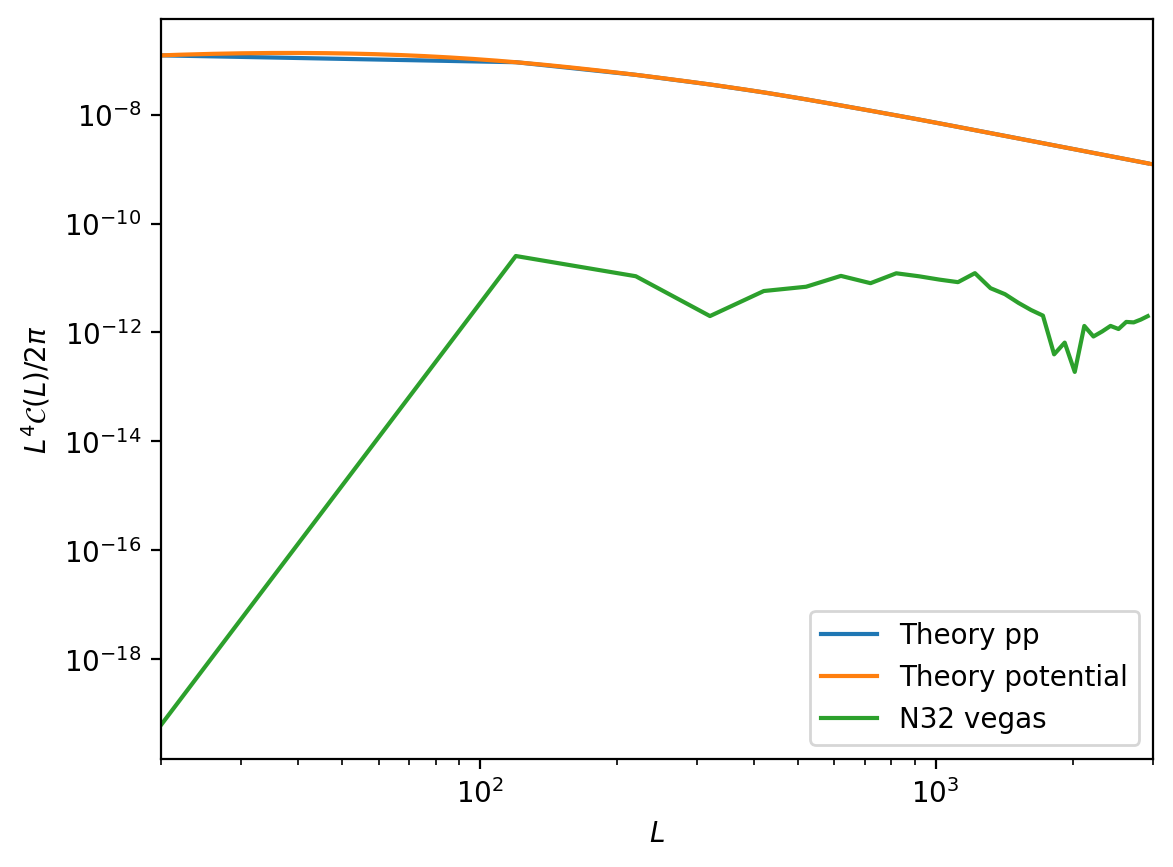

In [ ]:
plt.loglog(Ls, Ls**4*ppinterp/2/np.pi, label = 'Theory pp')
#plt.loglog(l, l**4*potential/2/np.pi, label = 'Theory potential')
plt.loglog(Ls, Ls**4*ALinterp*abs(NA1+NC1)/2/np.pi, label = 'N32 vegas')
plt.legend()
plt.ylabel(r"$L^4\mathcal{C}(L)/2\pi$")
plt.xlabel(r"$L$")
plt.xlim(20, 3000)

(20.0, 3000.0)

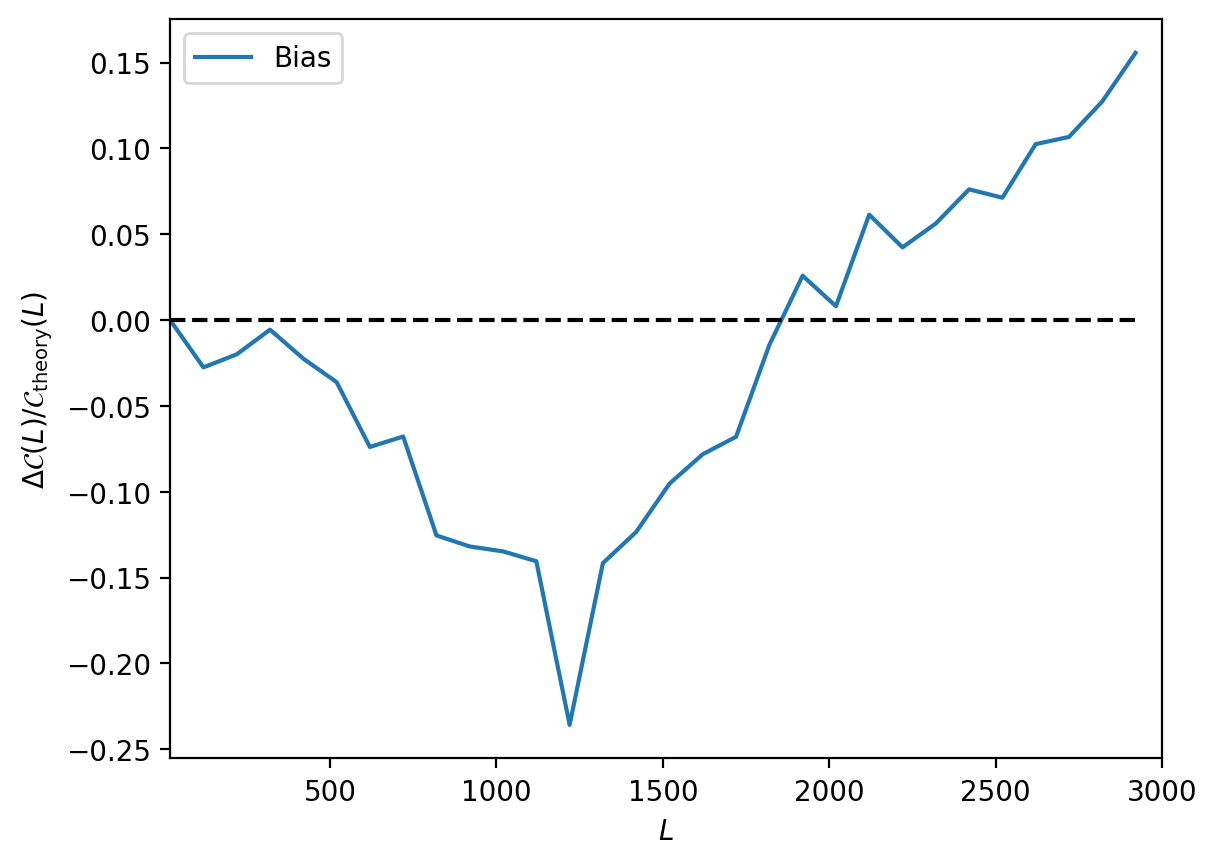

In [245]:
plt.plot(Ls, ALinterp*(NA1+NC1)/ppinterp*100, label = 'Bias')
plt.ylabel(r"$\Delta\mathcal{C}(L)/\mathcal{C}_{\rm theory}(L)$")
plt.plot(Ls, Ls*0, 'k--')
plt.xlabel(r"$L$")
plt.legend()
plt.xlim(20, 3000)

In [ ]:
## check bias in function of noise